&emsp;&emsp;川普号称“推特治国”，[本数据集]((https://www.kaggle.com/kingburrito666/better-donald-trump-tweets))收集了川普 2015 年 7 月到 2016 年 11 月七千余条推特的内容，并尝试使用 LSI 和 LDA 提取其主题。

## 0 导入包

In [1]:
# 科学计算
import numpy as np
# 数据处理和导入导出
import pandas as pd

# 数据可视化
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from matplotlib.colors import rgb2hex
plt.style.use('ggplot') #使用 ggplot 主题
# 更好的可视化效果
import seaborn as sns
sns.set_style("whitegrid") #设置 Seaborn 主题
# 创建可视化交互图形
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True) #使用 jupyter notebook 模式

# 词云
from wordcloud import WordCloud
from imageio import imread #读取图片

# 矢量化文本
from sklearn.feature_extraction.text import CountVectorizer
# 相关模型
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import PCA
# 可视化高维数据集
from sklearn.manifold import TSNE

# 使用新的数据类型
from collections import Counter

# 停用词
from nltk.corpus import stopwords
stop = stopwords.words('english')

## 1 准备数据

&emsp;&emsp;导入数据，并将 Tweet_Text 列为 `NaN` 的行删除。

In [2]:
# 导入数据
df = pd.read_csv('data/Donald-Tweets!.csv', header=0).rename(columns={'twt_favourites_IS_THIS_LIKE_QUESTION_MARK':'Tweet_Like'}).dropna(subset=['Tweet_Text'], axis=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7375 entries, 0 to 7374
Data columns (total 12 columns):
Date           7375 non-null object
Time           7375 non-null object
Tweet_Text     7375 non-null object
Type           7375 non-null object
Media_Type     1225 non-null object
Hashtags       2031 non-null object
Tweet_Id       7375 non-null float64
Tweet_Url      7375 non-null object
Tweet_Like     7375 non-null int64
Retweets       7375 non-null int64
Unnamed: 10    26 non-null float64
Unnamed: 11    13 non-null float64
dtypes: float64(3), int64(2), object(7)
memory usage: 749.0+ KB


In [3]:
# 查看 5 条样本数据
df.sample(5)

,Date,Time,Tweet_Text,Type,Media_Type,Hashtags,Tweet_Id,Tweet_Url,Tweet_Like,Retweets,Unnamed: 10,Unnamed: 11
1919,16-05-24,14:35:32,A great new book has been written about Crooke...,link,NaN,NaN,7.350000e+17,https://twitter.com/realDonaldTrump/status/735...,12479,6349,NaN,NaN
4645,15-11-24,20:54:08,"Heading to Myrtle Beach, South Carolina. Reall...",text,NaN,NaN,6.690000e+17,https://twitter.com/realDonaldTrump/status/669...,3514,1187,NaN,NaN
5031,15-11-06,16:46:22,"""@Robostop10: @realDonaldTrump This is not goo...",link,NaN,NaN,6.630000e+17,https://twitter.com/realDonaldTrump/status/662...,1604,965,NaN,NaN
609,16-10-05,1:21:57,RT @mike_pence: There۪s one clear choice in th...,text,photo,VPDebate,7.830000e+17,https://twitter.com/realDonaldTrump/status/783...,24717,12872,NaN,NaN
2398,16-04-10,3:02:23,"""@Mutual408Grace: @realDonaldTrump @gene70 Cal...",text,NaN,NaN,7.190000e+17,https://twitter.com/realDonaldTrump/status/718...,8389,2582,NaN,NaN


&emsp;&emsp;通过查看样本数据，发现第 10、11 列没有列名，且所有值均为 `NaN`，直接将这两列删除。

In [4]:
# 删除空白的第 10、 11 未命名列
del df['Unnamed: 10']
del df['Unnamed: 11']

In [5]:
# 查看是否删除成功
df.sample()

,Date,Time,Tweet_Text,Type,Media_Type,Hashtags,Tweet_Id,Tweet_Url,Tweet_Like,Retweets
4895,15-11-12,11:41:07,.@WSJ Editorial Board should review my debate ...,text,NaN,NaN,6.650000e+17,https://twitter.com/realDonaldTrump/status/664...,2438,1093


&emsp;&emsp;另外，Tweet_Id 列的所有记录均被转换为了科学计数法，而根据 Tweet 的 URL 命名规则，实际上 URL 最后一部分就是 Tweet_Id。因此，将 Tweet_Url 中的 Id 提取出来并替换 Tweet_Id。

In [6]:
# 替换 Tweet ID
df['Tweet_Id'] = df['Tweet_Url'].str[43:]

In [7]:
df.sample()

,Date,Time,Tweet_Text,Type,Media_Type,Hashtags,Tweet_Id,Tweet_Url,Tweet_Like,Retweets
1938,16-05-22,12:47:48,Hillary Clinton is not qualified to be preside...,text,NaN,NaN,734365143635759104,https://twitter.com/realDonaldTrump/status/734...,30338,10699


## 2 词云

&emsp;&emsp;在进行主题提取前，先来看看川普推特内容的词云和常用词（出现频率最高的单词）。

In [8]:
# 设置并更新停用词
stopwords = set(stopwords.words('english'))
stopwords.update(['.', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}', '@', '#', 'rt', 'amp', 'realdonaldtrump', 'http', 'https', '/', '://', '_', 'co', 'trump', 'donald', 'makeamericagreatagain'])

In [9]:
# 设置遮罩
mask = imread('img/trump.jpg')

In [10]:
# 将 Tweet_Text 中所有内容变成字符串
twt_text = ''.join(pd.Series(df['Tweet_Text'].tolist()).astype(str)).lower()

In [11]:
type(twt_text)

str

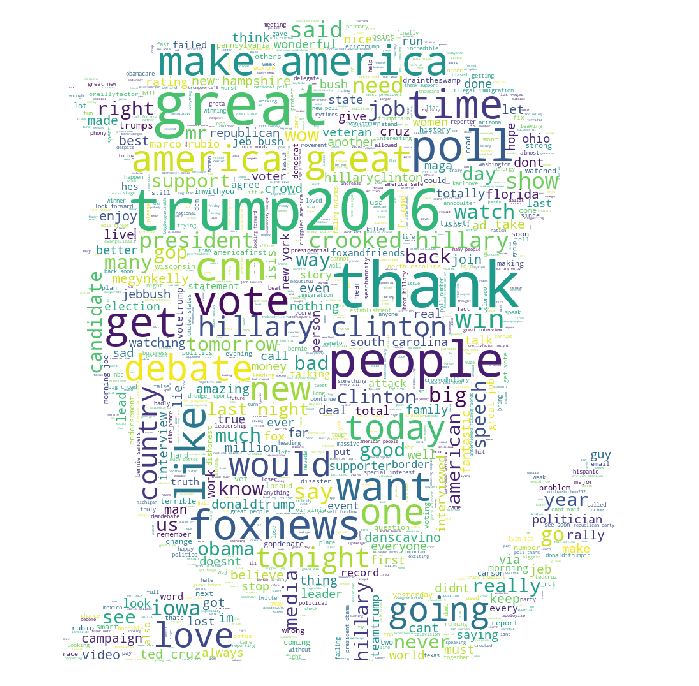

In [12]:
# 生成词云
cloud = WordCloud(
        background_color = 'white',
        stopwords = stopwords,
        mask = mask,
        max_words = 1024,
        max_font_size = 100
    )
    
word_cloud = cloud.generate(twt_text)
word_cloud.to_file('output\Trump_Cloud.jpg')

plt.figure(figsize=(12,12))
plt.imshow(word_cloud) 
plt.axis('off');

## 3 常用词

In [13]:
# 矢量化文本
countVectorizer = CountVectorizer(stop_words=stopwords)
vectorizedText = countVectorizer.fit_transform(df['Tweet_Text'].str.replace("'", '').values)
print('Shape Vectorized Text: {}'.format(vectorizedText.shape))

Shape Vectorized Text: (7375, 13690)


In [14]:
# 设置常用词数量
n = 20

In [15]:
def nMostFrequentWords(n, countVectorizer, vectorizedText):    
    """
        得出最常见的单词及其出现的次数
    
        Args:
            n: n most frequent words, int
            countVectorizer: CountVectorizer
            vectorizedText: vectorized text, string
            
        Returns:
            words: most frequent words, list
            wordCounts: count word appearences, list   
    """
    # 计算单词在文本中出现的次数
    vectorizedCount = np.sum(vectorizedText, axis=0)
    
    # 获取单词索引和计数
    wordIndices = np.flip(np.argsort(vectorizedCount), 1)
    wordCounts = np.flip(np.sort(vectorizedCount),1)

    # 创建单词向量
    wordVectors = np.zeros((n, vectorizedText.shape[1]))
    for i in range(n):
        wordVectors[i, wordIndices[0,i]] = 1

    # 逆转换单词向量
    words = [word[0].encode('ascii').decode('utf-8') for word in countVectorizer.inverse_transform(wordVectors)]

    # 返回最常见的单词及其出现的次数
    return (words, wordCounts[0, :n].tolist()[0])

In [16]:
words, wordCounts = nMostFrequentWords(n=n, countVectorizer=countVectorizer, vectorizedText=vectorizedText)

In [17]:
# 创建色彩映射
cmap = get_cmap('viridis')
colors = [rgb2hex(cmap(color)) for color in np.arange(0, 1.000001, 1/(n-1))]

In [18]:
# 生成柱状图
data = go.Bar(x = words,
              y = wordCounts,
              marker = dict(color = colors))

layout = go.Layout(title = 'Most Frequent {} Words In Trump Tweet'.format(n),
                   xaxis = dict(title = 'Words'),
                   yaxis = dict(title = 'Count'))

fig = go.Figure(data=[data], layout=layout)
iplot(fig)

&emsp;&emsp;接下来将使用 LSI 和 LDA 进行主题提取，关于这两个模型的原理和实现，以后有机会再具体讲述。

## 4 LSI

In [19]:
# 设置主题数
nTopics = 8

In [20]:
# 创建  LSI 模型
lsiModel = TruncatedSVD(n_components=nTopics)
lsiTopicMatrix = lsiModel.fit_transform(vectorizedText)
print('Shape LSI Topic Matrix: {}'.format(lsiTopicMatrix.shape))

Shape LSI Topic Matrix: (7375, 8)


In [21]:
# 获取最可能的键和所有类别的计数
lsiKeys = lsiTopicMatrix.argmax(axis=1)
lsiCategories, lsiCounts = zip(*Counter(lsiKeys).items())

In [22]:
def getTopWords(n, lsiKeys, vectorizedText, countVectorizer):
    """
        获得主题下的关键词
    
        Args:
            n: n top words, int
            lsiKeys: most probable keys, ndarray
            countVectorizer: CountVectorizer
            vectorizedText: vectorized text, csr_matrix
            
        Returns:
            topWords: top n words, list
    """
    # 为平均值创建零数组
    wordMean = np.zeros((nTopics, vectorizedText.shape[1]))
    # 迭代每个主题
    for i in np.unique(lsiKeys):
        wordMean[i] += vectorizedText.toarray()[lsiKeys==i].mean(axis=0)
        
    # 为每个主题排序并获得最常用的 n 个单词
    topWordsIndices = np.flip(np.argsort(wordMean, axis=1)[:, -n:], axis=1)
    topWordsPercentage = (np.divide(np.flip(np.sort(wordMean, axis=1)[:, -n:], axis=1), (np.sum(wordMean, axis=1)+0.0000001)[:, None])*100).astype(int)
    
     # 存储所有主题的所有单词
    topWords = []

    # 使用其索引迭代主题
    for i, (topic, percentage) in enumerate(zip(topWordsIndices, topWordsPercentage)):
        # Store all words for one topic
        topicWords = []

        if i in np.unique(lsiKeys):
            # 迭代主题的索引
            for index, percent in zip(topic, percentage):
                # 为索引创建一个wordvector
                wordVector = np.zeros((vectorizedText.shape[1]))
                wordVector[index] = 1
                # 反变换单词向量
                word = countVectorizer.inverse_transform(wordVector)[0][0]
                topicWords.append('{}% '.format(percent) + word.encode('ascii').decode('utf-8'))
        # 存储主题的所有单词
        topWords.append(', '.join(topicWords))

    return topWords

In [23]:
topWords = getTopWords(5, lsiKeys, vectorizedText, countVectorizer)

In [24]:
for i, words in enumerate(topWords):
    print('Topic {}: {}'.format(i, words))

Topic 0: 5% great, 4% thank, 1% america, 1% make, 1% trump2016
Topic 1: 
Topic 2: 2% hillary, 1% clinton, 1% crooked, 0% president, 0% would
Topic 3: 1% poll, 1% new, 1% cruz, 1% people, 1% big
Topic 4: 5% new, 4% trump2016, 4% poll, 2% america, 1% crippled
Topic 5: 4% trump2016, 1% people, 1% join, 0% tomorrow, 0% us
Topic 6: 3% get, 2% america, 2% vote, 0% like, 0% time
Topic 7: 2% foxnews, 1% tonight, 1% cnn, 1% enjoy, 1% interviewed


In [25]:
# 排序
lsiCategoriesSorted, lsiCountsSorted = zip(*sorted(zip(lsiCategories, lsiCounts)))

# 创建标签
topWords = getTopWords(5, lsiKeys, vectorizedText, countVectorizer)
labels = ['Topic {}'.format(i) for i in lsiCategoriesSorted]

# 创建色彩映射
n = nTopics
cmap = get_cmap('viridis')
colors = [rgb2hex(cmap(color)) for color in np.arange(0, 1.000001, 1/(n-1))]

# 生成柱状图
data = go.Bar(x = labels,
              y = lsiCountsSorted,
              text = [word for word in topWords if word],
              marker = dict(color = colors))

layout = go.Layout(title = 'Most Frequent LSI Topics In Trump Tweet',
                   xaxis = dict(title = 'Topic'),
                   yaxis = dict(title = 'Count'))

fig = go.Figure(data=[data], layout=layout)
iplot(fig)

In [26]:
# 降维高维数据集，使其在 2D 中可视化
tsneModel = TSNE(n_components=2, perplexity=50, learning_rate=100, n_iter=2000, verbose=1, random_state=0, angle=0.75)
tsneModelVectors = tsneModel.fit_transform(lsiTopicMatrix)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 7375 samples in 0.010s...
[t-SNE] Computed neighbors for 7375 samples in 0.725s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7375
[t-SNE] Computed conditional probabilities for sample 2000 / 7375
[t-SNE] Computed conditional probabilities for sample 3000 / 7375
[t-SNE] Computed conditional probabilities for sample 4000 / 7375
[t-SNE] Computed conditional probabilities for sample 5000 / 7375
[t-SNE] Computed conditional probabilities for sample 6000 / 7375
[t-SNE] Computed conditional probabilities for sample 7000 / 7375
[t-SNE] Computed conditional probabilities for sample 7375 / 7375
[t-SNE] Mean sigma: 0.016719
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.207245
[t-SNE] Error after 2000 iterations: 0.831852


In [27]:
# 创建色彩映射
n = nTopics
cmap = get_cmap('tab10')
colors = [rgb2hex(cmap(color)) for color in np.arange(0, 1.000001, 1/(n-1))]

# 获取关键词
topWords = getTopWords(3, lsiKeys, vectorizedText, countVectorizer)


# 生成散点图
data = []
# 迭代每个主题
for topic in range(nTopics):
    mask = lsiKeys==topic
    sample_mask = np.zeros(mask.sum()).astype(bool)
    sample_mask[:int(1000/nTopics)] = True
    np.random.shuffle(sample_mask)
    
    scatter = go.Scatter(x = tsneModelVectors[mask,0][sample_mask],
                         y = tsneModelVectors[mask,1][sample_mask],
                         name = 'Topic {}: {}'.format(topic, topWords[topic]),
                         mode = 'markers',
                         text = df[mask]['Tweet_Text'][sample_mask],
                         marker = dict(color = colors[topic]))
    data.append(scatter)

layout = go.Layout(title = 't-SNE Clustering of {} LSI Topics'.format(nTopics),
                   showlegend=True,
                   hovermode = 'closest')

fig = go.Figure(data=data, layout=layout)
iplot(fig)

## 5 LDA

In [28]:
# 创建 LDA 模型
ldaModel = LatentDirichletAllocation(n_components=nTopics, learning_method='online', random_state=0, verbose=0)
ldaTopicMatrix = ldaModel.fit_transform(vectorizedText)
print('Shape LSI Topic Matrix: {}'.format(ldaTopicMatrix.shape))

Shape LSI Topic Matrix: (7375, 8)


In [29]:
# 获取最可能的键和所有类别的计数
ldaKeys = ldaTopicMatrix.argmax(axis=1)
ldaCategories, ldaCounts = zip(*Counter(ldaKeys).items())

In [30]:
# 获取关键词
topWords = getTopWords(5, ldaKeys, vectorizedText, countVectorizer)

# 打印主题及其关键词
for i, words in enumerate(topWords):
    print('Topic {}: {}'.format(i, words))

Topic 0: 1% hillary, 1% clinton, 0% crooked, 0% people, 0% president
Topic 1: 2% trump2016, 2% great, 1% tonight, 1% thank, 1% enjoy
Topic 2: 1% great, 0% join, 0% thank, 0% country, 0% tomorrow
Topic 3: 0% thanks, 0% gop, 0% many, 0% america, 0% hillaryclinton
Topic 4: 1% hillary, 1% cruz, 0% poll, 0% ted, 0% cnn
Topic 5: 3% thank, 2% great, 2% new, 1% poll, 1% trump2016
Topic 6: 4% great, 3% america, 2% make, 1% thank, 0% trump2016
Topic 7: 1% thank, 1% trump2016, 1% like, 0% great, 0% see


In [31]:
# 排序
ldaCategoriesSorted, ldaCountsSorted = zip(*sorted(zip(ldaCategories, ldaCounts)))

# 创建标签
topWords = getTopWords(5, ldaKeys, vectorizedText, countVectorizer)
labels = ['Topic {}'.format(i) for i in ldaCategoriesSorted]

# 创建色彩映射
n = nTopics
cmap = get_cmap('viridis')
colors = [rgb2hex(cmap(color)) for color in np.arange(0, 1.000001, 1/(n-1))]

# 生成柱状图
data = go.Bar(x = labels,
              y = ldaCountsSorted,
              text = [word for word in topWords if word],
              marker = dict(color = colors))

layout = go.Layout(title = 'Most Frequent LDA Topics In Trump Tweet',
                   xaxis = dict(title = 'Topic'),
                   yaxis = dict(title = 'Count'))

fig = go.Figure(data=[data], layout=layout)
iplot(fig)

In [32]:
# 降维高维数据集，使其在 2D 中可视化
tsneModel = TSNE(n_components=2, perplexity=50, learning_rate=100, n_iter=2000, verbose=1, random_state=0, angle=0.75)
tsneModelVectors = tsneModel.fit_transform(ldaTopicMatrix)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 7375 samples in 0.008s...
[t-SNE] Computed neighbors for 7375 samples in 0.717s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7375
[t-SNE] Computed conditional probabilities for sample 2000 / 7375
[t-SNE] Computed conditional probabilities for sample 3000 / 7375
[t-SNE] Computed conditional probabilities for sample 4000 / 7375
[t-SNE] Computed conditional probabilities for sample 5000 / 7375
[t-SNE] Computed conditional probabilities for sample 6000 / 7375
[t-SNE] Computed conditional probabilities for sample 7000 / 7375
[t-SNE] Computed conditional probabilities for sample 7375 / 7375
[t-SNE] Mean sigma: 0.068215
[t-SNE] KL divergence after 250 iterations with early exaggeration: 76.528473
[t-SNE] Error after 2000 iterations: 1.265168


In [33]:
# 创建色彩映射
n = nTopics
cmap = get_cmap('tab10')
colors = [rgb2hex(cmap(color)) for color in np.arange(0, 1.000001, 1/(n-1))]

# 获取关键词
topWords = getTopWords(3, ldaKeys, vectorizedText, countVectorizer)

# 生成散点图
data = []
# 迭代每个主题
for topic in range(nTopics):
    mask = ldaKeys==topic
    sample_mask = np.zeros(mask.sum()).astype(bool)
    sample_mask[:int(1000/nTopics)] = True
    np.random.shuffle(sample_mask)
    
    scatter = go.Scatter(x = tsneModelVectors[mask,0][sample_mask],
                         y = tsneModelVectors[mask,1][sample_mask],
                         name = 'Topic {}: {}'.format(topic, topWords[topic]),
                         mode = 'markers',
                         text = df[mask]['Tweet_Text'][sample_mask],
                         marker = dict(color = colors[topic]))
    data.append(scatter)

layout = go.Layout(title = 't-SNE Clustering of {} LDA Topics'.format(nTopics),
                   showlegend=True,
                   hovermode = 'closest')

fig = go.Figure(data=data, layout=layout)
iplot(fig)

## 6 PCA

In [34]:
# 创建  PCA 模型
pcaModel = PCA(n_components=nTopics, random_state=0)
pcaTopicMatrix = pcaModel.fit_transform(vectorizedText.toarray())
print('Shape PCA Topic Matrix: {}'.format(pcaTopicMatrix.shape))

Shape PCA Topic Matrix: (7375, 8)


In [35]:
# 获取最可能的键和所有类别的计数
pcaKeys = pcaTopicMatrix.argmax(axis=1)
pcaCategories, pcaCounts = zip(*Counter(pcaKeys).items())

In [36]:
# 获取关键词数量
topWords = getTopWords(5, pcaKeys, vectorizedText, countVectorizer)

# 打印主题及其关键词
for i, words in enumerate(topWords):
    print('Topic {}: {}'.format(i, words))

Topic 0: 10% great, 2% america, 2% make, 2% thank, 0% people
Topic 1: 11% thank, 3% trump2016, 1% support, 1% nice, 0% new
Topic 2: 6% hillary, 4% clinton, 2% crooked, 0% bad, 0% bernie
Topic 3: 3% poll, 3% new, 1% cruz, 1% big, 1% debate
Topic 4: 1% america, 0% join, 0% jeb, 0% president, 0% make
Topic 5: 8% trump2016, 1% tomorrow, 1% join, 0% job, 0% danscavino
Topic 6: 2% people, 1% get, 1% like, 0% vote, 0% time
Topic 7: 2% foxnews, 2% cnn, 1% tonight, 1% enjoy, 1% interviewed


In [37]:
# 排序
pcaCategoriesSorted, pcaCountsSorted = zip(*sorted(zip(pcaCategories, pcaCounts)))

# 创建标签
topWords = getTopWords(5, pcaKeys, vectorizedText, countVectorizer)
labels = ['Topic {}'.format(i) for i in pcaCategoriesSorted]

# 创建色彩映射
n = nTopics
cmap = get_cmap('viridis')
colors = [rgb2hex(cmap(color)) for color in np.arange(0, 1.000001, 1/(n-1))]

# 生成柱状图
data = go.Bar(x = labels,
              y = pcaCountsSorted,
              text = [word for word in topWords if word],
              marker = dict(color = colors))

layout = go.Layout(title = 'Most Frequent PCA Topics In Trump Tweet',
                   xaxis = dict(title = 'Topic'),
                   yaxis = dict(title = 'Count'))

fig = go.Figure(data=[data], layout=layout)
iplot(fig)

In [38]:
# 降维高维数据集，使其在 2D 中可视化
tsneModel = TSNE(n_components=2, perplexity=50, learning_rate=100, n_iter=2000, verbose=1, random_state=0, angle=0.75)
tsneModelVectors = tsneModel.fit_transform(pcaTopicMatrix)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 7375 samples in 0.007s...
[t-SNE] Computed neighbors for 7375 samples in 0.658s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7375
[t-SNE] Computed conditional probabilities for sample 2000 / 7375
[t-SNE] Computed conditional probabilities for sample 3000 / 7375
[t-SNE] Computed conditional probabilities for sample 4000 / 7375
[t-SNE] Computed conditional probabilities for sample 5000 / 7375
[t-SNE] Computed conditional probabilities for sample 6000 / 7375
[t-SNE] Computed conditional probabilities for sample 7000 / 7375
[t-SNE] Computed conditional probabilities for sample 7375 / 7375
[t-SNE] Mean sigma: 0.018791
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.240501
[t-SNE] Error after 2000 iterations: 0.823488


In [39]:
# 创建色彩映射
n = nTopics
cmap = get_cmap('tab10')
colors = [rgb2hex(cmap(color)) for color in np.arange(0, 1.000001, 1/(n-1))]

# 获取关键词
topWords = getTopWords(3, pcaKeys, vectorizedText, countVectorizer)


# 生成散点图
data = []
# 迭代每个主题
for topic in range(nTopics):
    mask = pcaKeys==topic
    sample_mask = np.zeros(mask.sum()).astype(bool)
    sample_mask[:int(1000/nTopics)] = True
    np.random.shuffle(sample_mask)
    
    scatter = go.Scatter(x = tsneModelVectors[mask,0][sample_mask],
                         y = tsneModelVectors[mask,1][sample_mask],
                         name = 'Topic {}: {}'.format(topic, topWords[topic]),
                         mode = 'markers',
                         text = df[mask]['Tweet_Text'][sample_mask],
                         marker = dict(color = colors[topic]))
    data.append(scatter)

layout = go.Layout(title = 't-SNE Clustering of {} PCA Topics'.format(nTopics),
                   showlegend=True,
                   hovermode = 'closest')

fig = go.Figure(data=data, layout=layout)
iplot(fig)